Epoch 1/10
48/48 [==============================] - 2s 5ms/step - loss: 0.5791
Epoch 2/10
48/48 [==============================] - 0s 5ms/step - loss: 0.1632
Epoch 3/10
48/48 [==============================] - 0s 6ms/step - loss: 0.0864
Epoch 4/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0188
Epoch 5/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 6/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 7/10
48/48 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 8/10
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 9/10
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 10/10
379/379 [==============================] - 1s 2ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


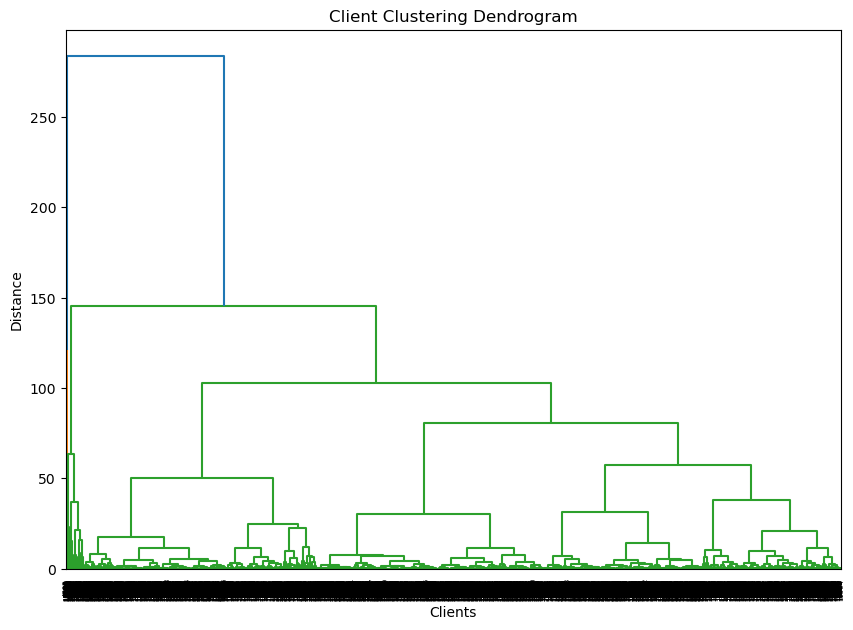

                                               Client_ID           Cluster
0                           100 LIMITES TRANSPORTES LTDA       Gold-client
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...       Gold-client
2                                   153 TRANSPORTES LTDA       Gold-client
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS  Declining-client
4                    19.450.581 JARDEL DE ABREU SANDOVAL       Hibernating
...                                                  ...               ...
12103                              ZOOM TRANSPORTES LTDA       Gold-client
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA       Gold-client
12105                            ZORTEA CONSTRUCOES LTDA  Declining-client
12106                     ZT COMERCIO E TRANSPORTES LTDA       Gold-client
12107                          ZUCOLOTO TRANSPORTES LTDA       Gold-client

[12108 rows x 2 columns]


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc

# Load and preprocess the data
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
data = pd.read_csv(file_path)

# Handle missing Brand_Name
data['Brand_Name'].fillna('Unknown', inplace=True)

# Convert Sales_Date to datetime
data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])

# Calculate RFM scores
today = datetime.now()
data['Recency'] = (today - data['Sales_Date']).dt.days
rfm = data.groupby('Client_ID').agg({
    'Recency': 'min',
    'Sales_Date': 'count',  # Frequency
    'Monetary_Value': 'sum'  # Monetary
}).rename(columns={'Sales_Date': 'Frequency'}).reset_index()

# Normalize RFM scores
scaler = StandardScaler()
rfm[['Recency', 'Frequency', 'Monetary_Value']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value']])

# Define Deep Clustering Network
class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])

    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = rfm.shape[1] - 1  # Exclude Client_ID
latent_dim = 3
dcn = DCN(input_dim, latent_dim)
dcn.compile(optimizer='adam', loss='mse')

# Train the DCN
features = rfm[['Recency', 'Frequency', 'Monetary_Value']].values
dcn.fit(features, features, epochs=10, batch_size=256, verbose=1)

# Extract latent features
latent_features = dcn.encoder.predict(features)

# Cluster using k-means
kmeans = KMeans(n_clusters=7, random_state=0).fit(latent_features)
rfm['Cluster'] = kmeans.labels_

# Define cluster names
cluster_names = ["Gold-client", "VIP", "Rising-star", "Declining-client", "Hibernating", "Sleeping", "Lost"]
rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(7), cluster_names)))

# Plot tree chart
plt.figure(figsize=(10, 7))
dendrogram = shc.dendrogram(shc.linkage(latent_features, method='ward'))
plt.title('Client Clustering Dendrogram')
plt.xlabel('Clients')
plt.ylabel('Distance')
plt.show()

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


Epoch 1/10
48/48 [==============================] - 2s 5ms/step - loss: 0.4685
Epoch 2/10
48/48 [==============================] - 0s 5ms/step - loss: 0.1023
Epoch 3/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0403
Epoch 4/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0179
Epoch 5/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 6/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0083
Epoch 7/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 8/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 10/10
379/379 [==============================] - 1s 2ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


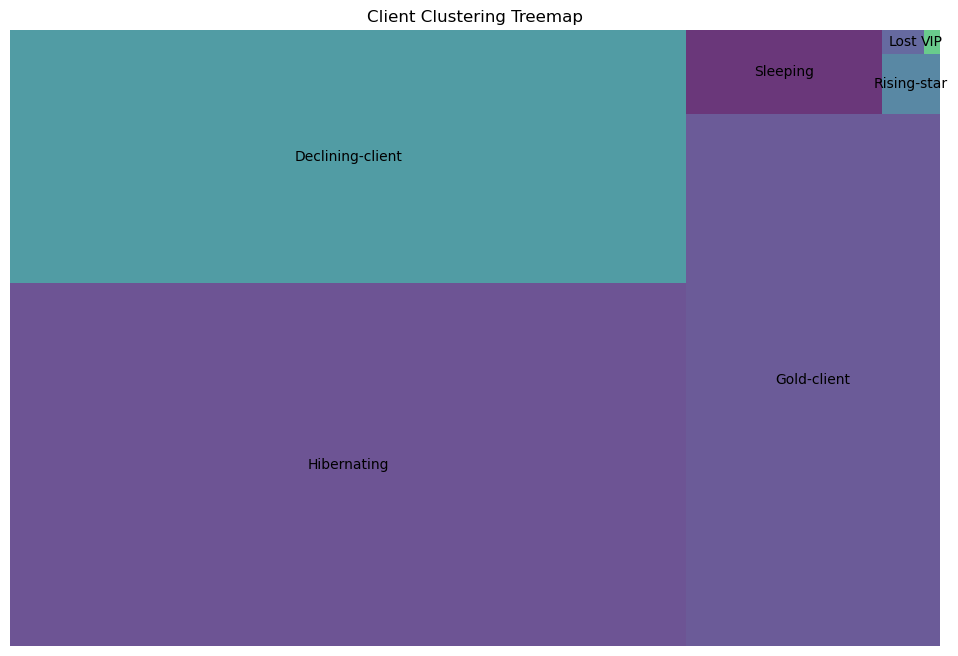

                                               Client_ID           Cluster
0                           100 LIMITES TRANSPORTES LTDA       Hibernating
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...       Hibernating
2                                   153 TRANSPORTES LTDA       Hibernating
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS       Gold-client
4                    19.450.581 JARDEL DE ABREU SANDOVAL  Declining-client
...                                                  ...               ...
12103                              ZOOM TRANSPORTES LTDA       Hibernating
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA       Hibernating
12105                            ZORTEA CONSTRUCOES LTDA       Gold-client
12106                     ZT COMERCIO E TRANSPORTES LTDA       Gold-client
12107                          ZUCOLOTO TRANSPORTES LTDA       Hibernating

[12108 rows x 2 columns]


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# Load and preprocess the data
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
data = pd.read_csv(file_path)

# Handle missing Brand_Name
data['Brand_Name'].fillna('Unknown', inplace=True)

# Convert Sales_Date to datetime
data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])

# Calculate RFM scores
today = datetime.now()
data['Recency'] = (today - data['Sales_Date']).dt.days
rfm = data.groupby('Client_ID').agg({
    'Recency': 'min',
    'Sales_Date': 'count',  # Frequency
    'Monetary_Value': 'sum'  # Monetary
}).rename(columns={'Sales_Date': 'Frequency'}).reset_index()

# Normalize RFM scores
scaler = StandardScaler()
rfm[['Recency', 'Frequency', 'Monetary_Value']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value']])

# Define Deep Clustering Network
class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])

    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = rfm.shape[1] - 1  # Exclude Client_ID
latent_dim = 3
dcn = DCN(input_dim, latent_dim)
dcn.compile(optimizer='adam', loss='mse')

# Train the DCN
features = rfm[['Recency', 'Frequency', 'Monetary_Value']].values
dcn.fit(features, features, epochs=10, batch_size=256, verbose=1)

# Extract latent features
latent_features = dcn.encoder.predict(features)

# Cluster using k-means
kmeans = KMeans(n_clusters=7, random_state=0).fit(latent_features)
rfm['Cluster'] = kmeans.labels_

# Define cluster names
cluster_names = ["Gold-client", "VIP", "Rising-star", "Declining-client", "Hibernating", "Sleeping", "Lost"]
rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(7), cluster_names)))

# Calculate cluster sizes
cluster_sizes = rfm['Cluster'].value_counts(normalize=True) * 100
cluster_labels = cluster_sizes.index.tolist()
sizes = cluster_sizes.values.tolist()

# Plot treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=cluster_labels, alpha=0.8)
plt.axis('off')
plt.title('Client Clustering Treemap')
plt.show()

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


Epoch 1/10
48/48 [==============================] - 2s 6ms/step - loss: 0.7593
Epoch 2/10
48/48 [==============================] - 0s 6ms/step - loss: 0.5112
Epoch 3/10
48/48 [==============================] - 0s 7ms/step - loss: 0.4397
Epoch 4/10
48/48 [==============================] - 0s 5ms/step - loss: 0.2771
Epoch 5/10
48/48 [==============================] - 0s 5ms/step - loss: 0.1305
Epoch 6/10
48/48 [==============================] - 0s 5ms/step - loss: 0.1132
Epoch 7/10
48/48 [==============================] - 0s 6ms/step - loss: 0.0968
Epoch 8/10
48/48 [==============================] - 0s 6ms/step - loss: 0.0609
Epoch 9/10
48/48 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 10/10
379/379 [==============================] - 1s 3ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


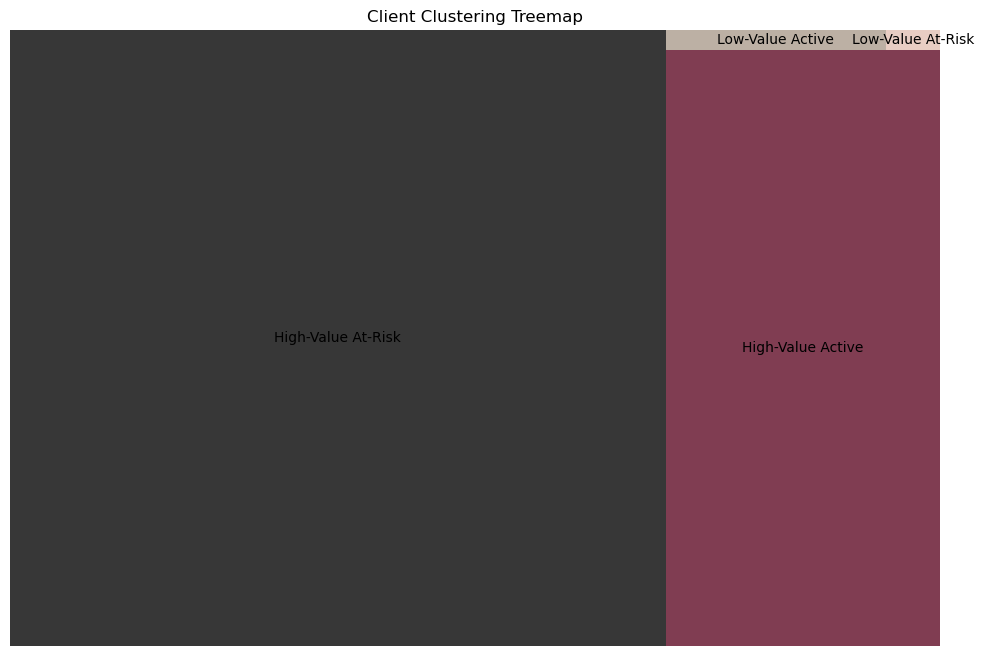

                                               Client_ID             Cluster
0                           100 LIMITES TRANSPORTES LTDA  High-Value At-Risk
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...  High-Value At-Risk
2                                   153 TRANSPORTES LTDA  High-Value At-Risk
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS   High-Value Active
4                    19.450.581 JARDEL DE ABREU SANDOVAL  High-Value At-Risk
...                                                  ...                 ...
12103                              ZOOM TRANSPORTES LTDA   High-Value Active
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA  High-Value At-Risk
12105                            ZORTEA CONSTRUCOES LTDA   High-Value Active
12106                     ZT COMERCIO E TRANSPORTES LTDA   High-Value Active
12107                          ZUCOLOTO TRANSPORTES LTDA  High-Value At-Risk

[12108 rows x 2 columns]


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import squarify

# Load and preprocess the data
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
data = pd.read_csv(file_path)

# Handle missing Brand_Name
data['Brand_Name'].fillna('Unknown', inplace=True)

# Convert Sales_Date to datetime
data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])

# Calculate RFM scores
today = datetime.now()
data['Recency'] = (today - data['Sales_Date']).dt.days
rfm = data.groupby('Client_ID').agg({
    'Recency': 'min',
    'Sales_Date': 'count',  # Frequency
    'Monetary_Value': 'sum'  # Monetary
}).rename(columns={'Sales_Date': 'Frequency'}).reset_index()

# Calculate churn index
def calculate_churn_index(row):
    # Simple churn index: inverse of frequency, higher recency, and low monetary value indicate higher churn risk
    return (1 / (row['Frequency'] + 1)) * row['Recency'] * (1 / (row['Monetary_Value'] + 1))

rfm['Churn_Index'] = rfm.apply(calculate_churn_index, axis=1)

# Normalize RFM scores and churn index
scaler = StandardScaler()
rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']])

# Define Deep Clustering Network
class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])

    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = rfm.shape[1] - 1  # Exclude Client_ID
latent_dim = 3
dcn = DCN(input_dim, latent_dim)
dcn.compile(optimizer='adam', loss='mse')

# Train the DCN
features = rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']].values
dcn.fit(features, features, epochs=10, batch_size=256, verbose=1)

# Extract latent features
latent_features = dcn.encoder.predict(features)

# Cluster using k-means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(latent_features)
rfm['Cluster'] = kmeans.labels_

# Define cluster names
cluster_names = ["High-Value Active", "High-Value At-Risk", "Low-Value Active", "Low-Value At-Risk"]
rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(4), cluster_names)))

# Calculate cluster sizes
cluster_sizes = rfm['Cluster'].value_counts(normalize=True) * 100
cluster_labels = cluster_sizes.index.tolist()
sizes = cluster_sizes.values.tolist()

# Plot treemap with specified colors
colors = ["#050505", "#610C27", "#AC9C8D", "#E3C1B4"]
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=cluster_labels, alpha=0.8, color=colors)
plt.axis('off')
plt.title('Client Clustering Treemap')
plt.show()

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


Epoch 1/10
48/48 [==============================] - 2s 5ms/step - loss: 0.6636
Epoch 2/10
48/48 [==============================] - 0s 5ms/step - loss: 0.1921
Epoch 3/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0885
Epoch 4/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0453
Epoch 5/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0257
Epoch 6/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 7/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 8/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 9/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 10/10
379/379 [==============================] - 1s 2ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


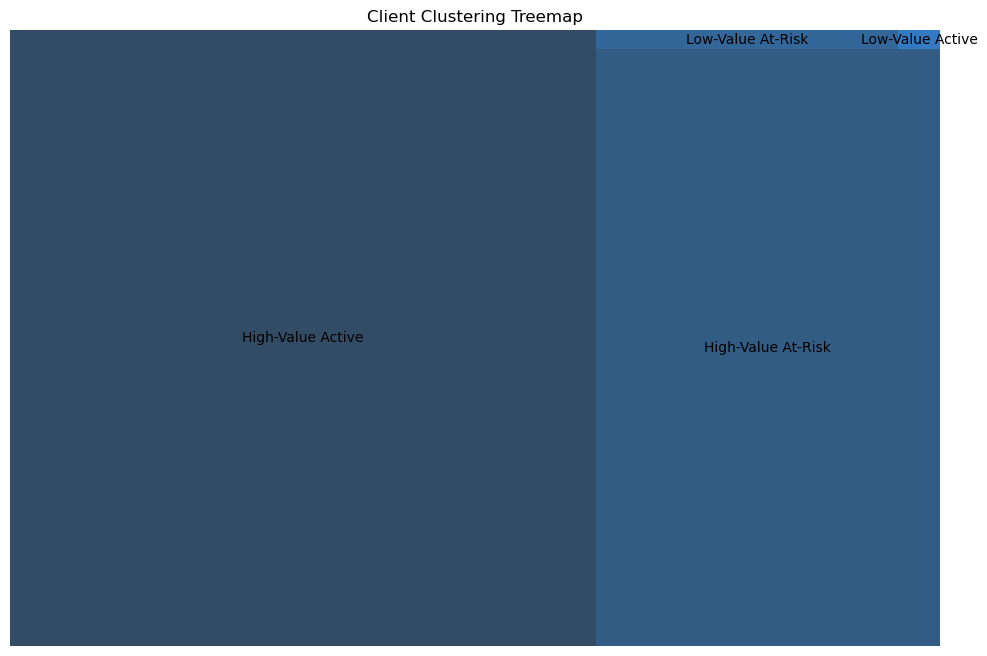

                                               Client_ID             Cluster
0                           100 LIMITES TRANSPORTES LTDA  High-Value At-Risk
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...   High-Value Active
2                                   153 TRANSPORTES LTDA   High-Value Active
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS   High-Value Active
4                    19.450.581 JARDEL DE ABREU SANDOVAL  High-Value At-Risk
...                                                  ...                 ...
12103                              ZOOM TRANSPORTES LTDA   High-Value Active
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA   High-Value Active
12105                            ZORTEA CONSTRUCOES LTDA   High-Value Active
12106                     ZT COMERCIO E TRANSPORTES LTDA   High-Value Active
12107                          ZUCOLOTO TRANSPORTES LTDA   High-Value Active

[12108 rows x 2 columns]


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import squarify

# Load and preprocess the data
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
data = pd.read_csv(file_path)

# Handle missing Brand_Name
data['Brand_Name'].fillna('Unknown', inplace=True)

# Convert Sales_Date to datetime
data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])

# Calculate RFM scores
today = datetime.now()
data['Recency'] = (today - data['Sales_Date']).dt.days
rfm = data.groupby('Client_ID').agg({
    'Recency': 'min',
    'Sales_Date': 'count',  # Frequency
    'Monetary_Value': 'sum'  # Monetary
}).rename(columns={'Sales_Date': 'Frequency'}).reset_index()

# Calculate churn index
def calculate_churn_index(row):
    # Simple churn index: inverse of frequency, higher recency, and low monetary value indicate higher churn risk
    return (1 / (row['Frequency'] + 1)) * row['Recency'] * (1 / (row['Monetary_Value'] + 1))

rfm['Churn_Index'] = rfm.apply(calculate_churn_index, axis=1)

# Normalize RFM scores and churn index
scaler = StandardScaler()
rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']])

# Define Deep Clustering Network
class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])

    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = rfm.shape[1] - 1  # Exclude Client_ID
latent_dim = 3
dcn = DCN(input_dim, latent_dim)
dcn.compile(optimizer='adam', loss='mse')

# Train the DCN
features = rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']].values
dcn.fit(features, features, epochs=10, batch_size=256, verbose=1)

# Extract latent features
latent_features = dcn.encoder.predict(features)

# Cluster using k-means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(latent_features)
rfm['Cluster'] = kmeans.labels_

# Define cluster names
cluster_names = ["High-Value Active", "High-Value At-Risk", "Low-Value Active", "Low-Value At-Risk"]
rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(4), cluster_names)))

# Calculate cluster sizes
cluster_sizes = rfm['Cluster'].value_counts(normalize=True) * 100
cluster_labels = cluster_sizes.index.tolist()
sizes = cluster_sizes.values.tolist()

# Plot treemap with navy colors
colors = ["#001f3f", "#003366", "#004080", "#0059b3"]  # Various shades of navy
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=cluster_labels, alpha=0.8, color=colors)
plt.axis('off')
plt.title('Client Clustering Treemap')
plt.show()

# Save the clustering results to a CSV file
output_file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Clustering_Results.csv'
rfm.to_csv(output_file_path, index=False)

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


Epoch 1/10
190/190 [==============================] - 3s 5ms/step - loss: 0.2540
Epoch 2/10
190/190 [==============================] - 1s 5ms/step - loss: 0.0438
Epoch 3/10
190/190 [==============================] - 1s 4ms/step - loss: 0.0102
Epoch 4/10
190/190 [==============================] - 1s 5ms/step - loss: 0.0080
Epoch 5/10
190/190 [==============================] - 1s 4ms/step - loss: 0.0294
Epoch 6/10
190/190 [==============================] - 1s 5ms/step - loss: 0.0098
Epoch 7/10
190/190 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 8/10
190/190 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 9/10
190/190 [==============================] - 1s 5ms/step - loss: 0.0079
Epoch 10/10
379/379 [==============================] - 1s 3ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


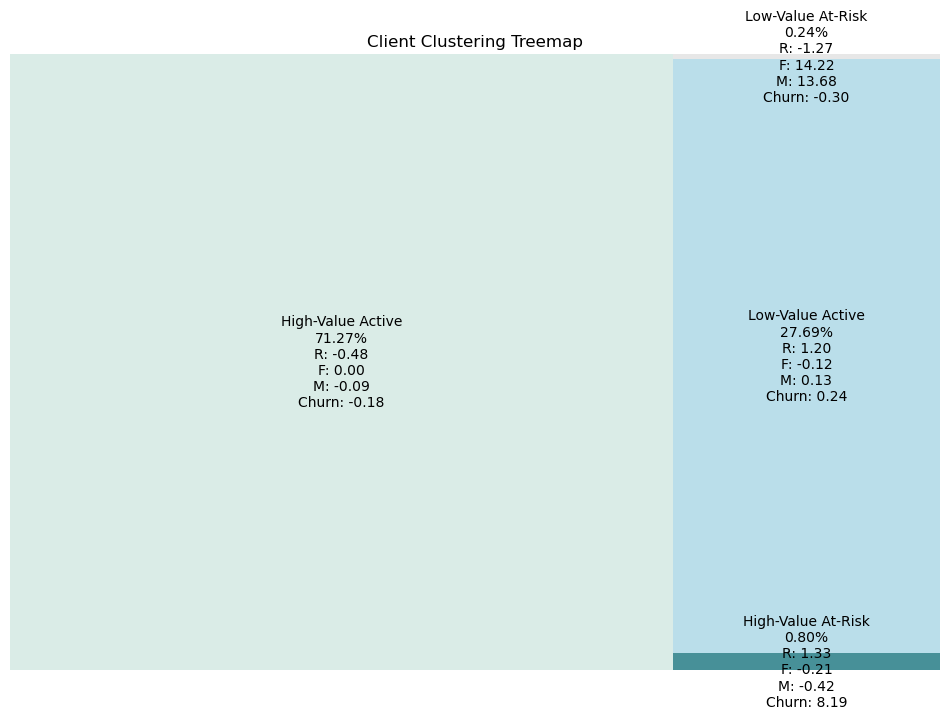

                                               Client_ID            Cluster
0                           100 LIMITES TRANSPORTES LTDA  High-Value Active
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...  High-Value Active
2                                   153 TRANSPORTES LTDA  High-Value Active
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS   Low-Value Active
4                    19.450.581 JARDEL DE ABREU SANDOVAL  High-Value Active
...                                                  ...                ...
12103                              ZOOM TRANSPORTES LTDA   Low-Value Active
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA  High-Value Active
12105                            ZORTEA CONSTRUCOES LTDA   Low-Value Active
12106                     ZT COMERCIO E TRANSPORTES LTDA   Low-Value Active
12107                          ZUCOLOTO TRANSPORTES LTDA  High-Value Active

[12108 rows x 2 columns]


In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import squarify

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Brand_Name'].fillna('Unknown', inplace=True)
    data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])
    today = datetime.now()
    data['Recency'] = (today - data['Sales_Date']).dt.days
    rfm = data.groupby('Client_ID').agg({
        'Recency': 'min',
        'Sales_Date': 'count',  # Frequency
        'Monetary_Value': 'sum'  # Monetary
    }).rename(columns={'Sales_Date': 'Frequency'}).reset_index()
    return rfm

def calculate_churn_index(rfm):
    def churn_index(row):
        return (1 / (row['Frequency'] + 1)) * row['Recency'] * (1 / (row['Monetary_Value'] + 1))
    rfm['Churn_Index'] = rfm.apply(churn_index, axis=1)
    return rfm

def normalize_features(rfm):
    scaler = StandardScaler()
    rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']])
    return rfm

class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])
    
    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

def train_dcn(features, input_dim, latent_dim=3, epochs=10, batch_size=64):
    dcn = DCN(input_dim, latent_dim)
    dcn.compile(optimizer='adam', loss='mse')
    dcn.fit(features, features, epochs=epochs, batch_size=batch_size, verbose=1)
    latent_features = dcn.encoder.predict(features)
    return latent_features

def perform_clustering(latent_features, rfm, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent_features)
    rfm['Cluster'] = kmeans.labels_
    return rfm

def define_cluster_names(rfm):
    cluster_names = ["High-Value Active", "High-Value At-Risk", "Low-Value Active", "Low-Value At-Risk"]
    rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(4), cluster_names)))
    return rfm

def plot_treemap(rfm):
    cluster_stats = rfm.groupby('Cluster').agg({
        'Client_ID': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': 'mean',
        'Churn_Index': 'mean'
    }).rename(columns={'Client_ID': 'Count'}).reset_index()
    
    cluster_stats['Percentage'] = (cluster_stats['Count'] / cluster_stats['Count'].sum()) * 100
    cluster_stats['Label'] = cluster_stats.apply(lambda row: f"{row['Cluster']}\n{row['Percentage']:.2f}%\nR: {row['Recency']:.2f}\nF: {row['Frequency']:.2f}\nM: {row['Monetary_Value']:.2f}\nChurn: {row['Churn_Index']:.2f}", axis=1)
    
    sizes = cluster_stats['Percentage'].tolist()
    labels = cluster_stats['Label'].tolist()
    colors = ["#D1E8E2", "#19747E", "#A9D6E5", "#E2E2E2"]
    
    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=colors)
    plt.axis('off')
    plt.title('Client Clustering Treemap')
    plt.show()

def save_clustering_results(rfm, output_file_path):
    rfm.to_csv(output_file_path, index=False)

# Main code execution
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
output_file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Clustering_Results.csv'

# Load and preprocess data
rfm = load_and_preprocess_data(file_path)

# Calculate churn index
rfm = calculate_churn_index(rfm)

# Normalize features
rfm = normalize_features(rfm)

# Train DCN
input_dim = rfm.shape[1] - 1  # Exclude Client_ID
features = rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']].values
latent_features = train_dcn(features, input_dim)

# Perform clustering
rfm = perform_clustering(latent_features, rfm)

# Define cluster names
rfm = define_cluster_names(rfm)

# Plot treemap
plot_treemap(rfm)

# Save clustering results
save_clustering_results(rfm, output_file_path)

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


Epoch 1/10
48/48 [==============================] - 2s 5ms/step - loss: 0.0158
Epoch 2/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 3/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 4/10
48/48 [==============================] - 0s 8ms/step - loss: 7.7757e-04
Epoch 5/10
48/48 [==============================] - 1s 16ms/step - loss: 2.8858e-04
Epoch 6/10
48/48 [==============================] - 0s 7ms/step - loss: 1.6434e-04
Epoch 7/10
48/48 [==============================] - 0s 8ms/step - loss: 7.3195e-05
Epoch 8/10
48/48 [==============================] - 0s 8ms/step - loss: 6.4553e-05
Epoch 9/10
48/48 [==============================] - 0s 6ms/step - loss: 5.8479e-05
Epoch 10/10
379/379 [==============================] - 1s 3ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


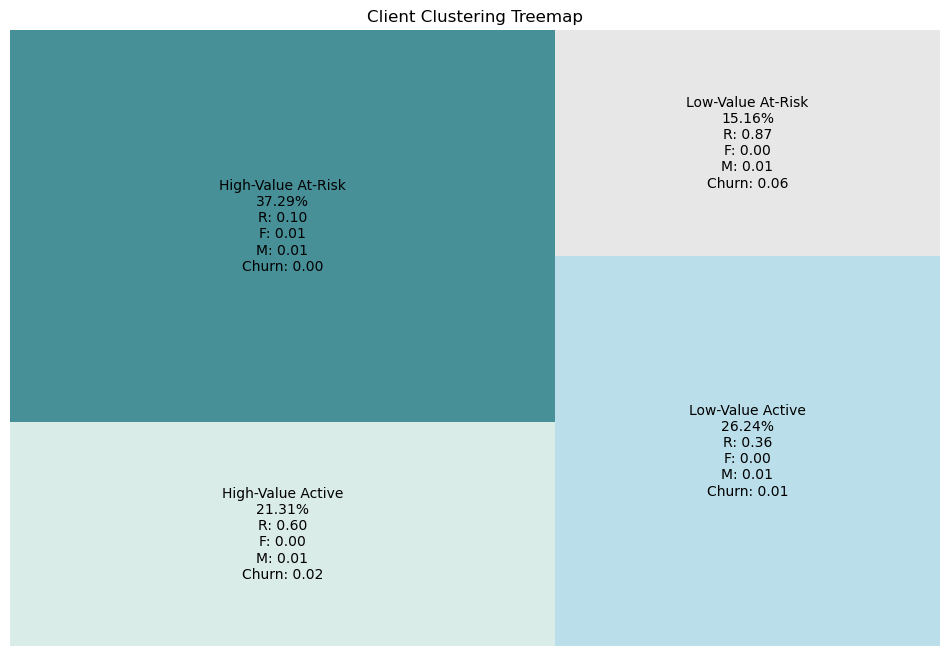

                                               Client_ID             Cluster
0                           100 LIMITES TRANSPORTES LTDA  High-Value At-Risk
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...   High-Value Active
2                                   153 TRANSPORTES LTDA   High-Value Active
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS   Low-Value At-Risk
4                    19.450.581 JARDEL DE ABREU SANDOVAL  High-Value At-Risk
...                                                  ...                 ...
12103                              ZOOM TRANSPORTES LTDA    Low-Value Active
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA  High-Value At-Risk
12105                            ZORTEA CONSTRUCOES LTDA   Low-Value At-Risk
12106                     ZT COMERCIO E TRANSPORTES LTDA   Low-Value At-Risk
12107                          ZUCOLOTO TRANSPORTES LTDA   High-Value Active

[12108 rows x 2 columns]


In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import squarify

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Brand_Name'].fillna('Unknown', inplace=True)
    data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])
    today = datetime.now()
    data['Recency'] = (today - data['Sales_Date']).dt.days
    rfm = data.groupby('Client_ID').agg({
        'Recency': 'min',
        'Sales_Date': 'count',  # Frequency
        'Monetary_Value': 'sum'  # Monetary
    }).rename(columns={'Sales_Date': 'Frequency'}).reset_index()
    return rfm

def calculate_churn_index(rfm):
    def churn_index(row):
        return (1 / (row['Frequency'] + 1)) * row['Recency'] * (1 / (row['Monetary_Value'] + 1))
    rfm['Churn_Index'] = rfm.apply(churn_index, axis=1)
    return rfm

def normalize_features(rfm):
    scaler = MinMaxScaler()
    rfm[['Recency', 'Frequency', 'Monetary_Value']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value']])
    rfm['Churn_Index'] = MinMaxScaler((0, 2)).fit_transform(rfm[['Churn_Index']])
    return rfm

class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])
    
    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

def train_dcn(features, input_dim, latent_dim=3, epochs=10, batch_size=256):
    dcn = DCN(input_dim, latent_dim)
    dcn.compile(optimizer='adam', loss='mse')
    dcn.fit(features, features, epochs=epochs, batch_size=batch_size, verbose=1)
    latent_features = dcn.encoder.predict(features)
    return latent_features

def perform_clustering(latent_features, rfm, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent_features)
    rfm['Cluster'] = kmeans.labels_
    return rfm

def define_cluster_names(rfm):
    cluster_names = ["High-Value Active", "High-Value At-Risk", "Low-Value Active", "Low-Value At-Risk"]
    rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(4), cluster_names)))
    return rfm

def plot_treemap(rfm):
    cluster_stats = rfm.groupby('Cluster').agg({
        'Client_ID': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': 'mean',
        'Churn_Index': 'mean'
    }).rename(columns={'Client_ID': 'Count'}).reset_index()
    
    cluster_stats['Percentage'] = (cluster_stats['Count'] / cluster_stats['Count'].sum()) * 100
    cluster_stats['Label'] = cluster_stats.apply(lambda row: f"{row['Cluster']}\n{row['Percentage']:.2f}%\nR: {row['Recency']:.2f}\nF: {row['Frequency']:.2f}\nM: {row['Monetary_Value']:.2f}\nChurn: {row['Churn_Index']:.2f}", axis=1)
    
    sizes = cluster_stats['Percentage'].tolist()
    labels = cluster_stats['Label'].tolist()
    colors = ["#D1E8E2", "#19747E", "#A9D6E5", "#E2E2E2"]
    
    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=colors)
    plt.axis('off')
    plt.title('Client Clustering Treemap')
    plt.show()

def save_clustering_results(rfm, output_file_path):
    rfm.to_csv(output_file_path, index=False)

# Main code execution
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
output_file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Clustering_Results.csv'

# Load and preprocess data
rfm = load_and_preprocess_data(file_path)

# Calculate churn index
rfm = calculate_churn_index(rfm)

# Normalize features
rfm = normalize_features(rfm)

# Train DCN
input_dim = rfm.shape[1] - 1  # Exclude Client_ID
features = rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']].values
latent_features = train_dcn(features, input_dim)

# Perform clustering
rfm = perform_clustering(latent_features, rfm)

# Define cluster names
rfm = define_cluster_names(rfm)

# Plot treemap
plot_treemap(rfm)

# Save clustering results
save_clustering_results(rfm, output_file_path)

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


Epoch 1/10
48/48 [==============================] - 2s 8ms/step - loss: 464.4138
Epoch 2/10
48/48 [==============================] - 0s 7ms/step - loss: 9.0928
Epoch 3/10
48/48 [==============================] - 0s 7ms/step - loss: 2.6460
Epoch 4/10
48/48 [==============================] - 0s 7ms/step - loss: 0.7858
Epoch 5/10
48/48 [==============================] - 0s 7ms/step - loss: 0.5570
Epoch 6/10
48/48 [==============================] - 0s 7ms/step - loss: 0.3197
Epoch 7/10
48/48 [==============================] - 0s 6ms/step - loss: 0.1346
Epoch 8/10
48/48 [==============================] - 0s 7ms/step - loss: 0.0697
Epoch 9/10
48/48 [==============================] - 0s 7ms/step - loss: 0.0292
Epoch 10/10
379/379 [==============================] - 2s 4ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


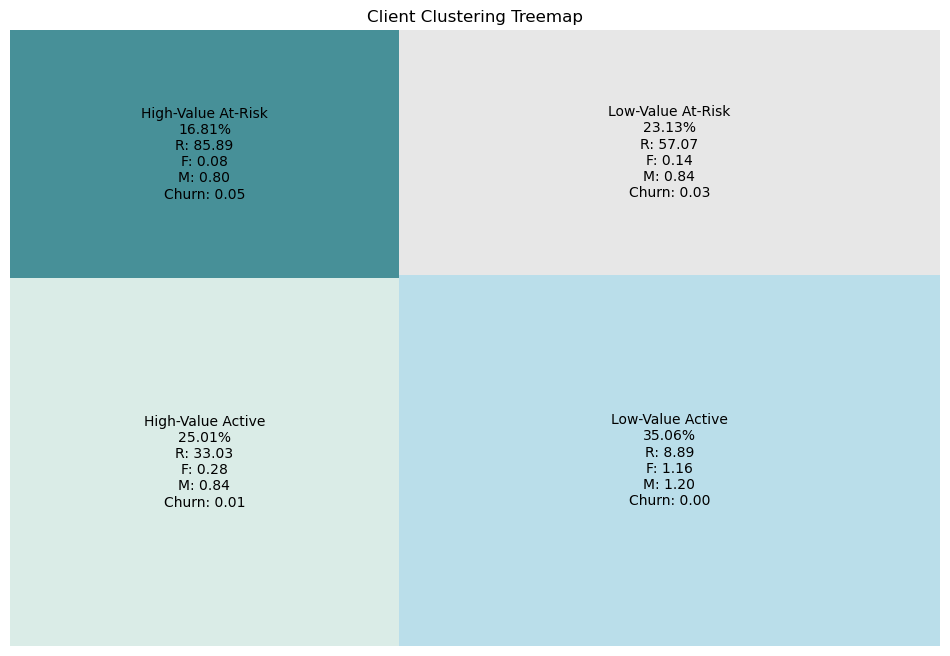

                                               Client_ID             Cluster
0                           100 LIMITES TRANSPORTES LTDA    Low-Value Active
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...   Low-Value At-Risk
2                                   153 TRANSPORTES LTDA   Low-Value At-Risk
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS  High-Value At-Risk
4                    19.450.581 JARDEL DE ABREU SANDOVAL    Low-Value Active
...                                                  ...                 ...
12103                              ZOOM TRANSPORTES LTDA   High-Value Active
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA   High-Value Active
12105                            ZORTEA CONSTRUCOES LTDA  High-Value At-Risk
12106                     ZT COMERCIO E TRANSPORTES LTDA  High-Value At-Risk
12107                          ZUCOLOTO TRANSPORTES LTDA   Low-Value At-Risk

[12108 rows x 2 columns]


In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import squarify

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Brand_Name'].fillna('Unknown', inplace=True)
    data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])
    today = datetime.now()
    data['Recency'] = (today - data['Sales_Date']).dt.days
    rfm = data.groupby('Client_ID').agg({
        'Recency': 'min',
        'Sales_Date': 'count',  # Frequency
        'Monetary_Value': 'sum'  # Monetary
    }).rename(columns={'Sales_Date': 'Frequency'}).reset_index()
    return rfm

def calculate_churn_index(rfm):
    def churn_index(row):
        return (1 / (row['Frequency'] + 1)) * row['Recency'] * (1 / (row['Monetary_Value'] + 1))
    rfm['Churn_Index'] = rfm.apply(churn_index, axis=1)
    return rfm

def normalize_features(rfm):
    scaler = MinMaxScaler(feature_range=(0, 100))
    rfm[['Recency', 'Frequency', 'Monetary_Value']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value']])
    rfm['Churn_Index'] = MinMaxScaler((0, 2)).fit_transform(rfm[['Churn_Index']].values.reshape(-1, 1))
    return rfm

class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])
    
    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

def train_dcn(features, input_dim, latent_dim=3, epochs=10, batch_size=256):
    dcn = DCN(input_dim, latent_dim)
    dcn.compile(optimizer='adam', loss='mse')
    dcn.fit(features, features, epochs=epochs, batch_size=batch_size, verbose=1)
    latent_features = dcn.encoder.predict(features)
    return latent_features

def perform_clustering(latent_features, rfm, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent_features)
    rfm['Cluster'] = kmeans.labels_
    return rfm

def define_cluster_names(rfm):
    cluster_names = ["High-Value Active", "High-Value At-Risk", "Low-Value Active", "Low-Value At-Risk"]
    rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(4), cluster_names)))
    return rfm

def plot_treemap(rfm):
    cluster_stats = rfm.groupby('Cluster').agg({
        'Client_ID': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': 'mean',
        'Churn_Index': 'mean'
    }).rename(columns={'Client_ID': 'Count'}).reset_index()
    
    cluster_stats['Percentage'] = (cluster_stats['Count'] / cluster_stats['Count'].sum()) * 100
    cluster_stats['Label'] = cluster_stats.apply(lambda row: f"{row['Cluster']}\n{row['Percentage']:.2f}%\nR: {row['Recency']:.2f}\nF: {row['Frequency']:.2f}\nM: {row['Monetary_Value']:.2f}\nChurn: {row['Churn_Index']:.2f}", axis=1)
    
    sizes = cluster_stats['Percentage'].tolist()
    labels = cluster_stats['Label'].tolist()
    colors = ["#D1E8E2", "#19747E", "#A9D6E5", "#E2E2E2"]
    
    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=colors)
    plt.axis('off')
    plt.title('Client Clustering Treemap')
    plt.show()

def save_clustering_results(rfm, output_file_path):
    rfm.to_csv(output_file_path, index=False)

# Main code execution
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
output_file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Clustering_Results.csv'

# Load and preprocess data
rfm = load_and_preprocess_data(file_path)

# Calculate churn index
rfm = calculate_churn_index(rfm)

# Normalize features
rfm = normalize_features(rfm)

# Train DCN
input_dim = rfm.shape[1] - 1  # Exclude Client_ID
features = rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']].values
latent_features = train_dcn(features, input_dim)

# Perform clustering
rfm = perform_clustering(latent_features, rfm)

# Define cluster names
rfm = define_cluster_names(rfm)

# Plot treemap
plot_treemap(rfm)

# Save clustering results
save_clustering_results(rfm, output_file_path)

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


Epoch 1/10
48/48 [==============================] - 2s 5ms/step - loss: 629862.5625
Epoch 2/10
48/48 [==============================] - 0s 5ms/step - loss: 4926.5327
Epoch 3/10
48/48 [==============================] - 0s 5ms/step - loss: 846.4490
Epoch 4/10
48/48 [==============================] - 0s 7ms/step - loss: 415.3618
Epoch 5/10
48/48 [==============================] - 0s 6ms/step - loss: 127.0755
Epoch 6/10
48/48 [==============================] - 0s 6ms/step - loss: 208.9185
Epoch 7/10
48/48 [==============================] - 0s 6ms/step - loss: 164.1924
Epoch 8/10
48/48 [==============================] - 0s 8ms/step - loss: 115.0300
Epoch 9/10
48/48 [==============================] - 0s 5ms/step - loss: 564.9716
Epoch 10/10
379/379 [==============================] - 1s 2ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


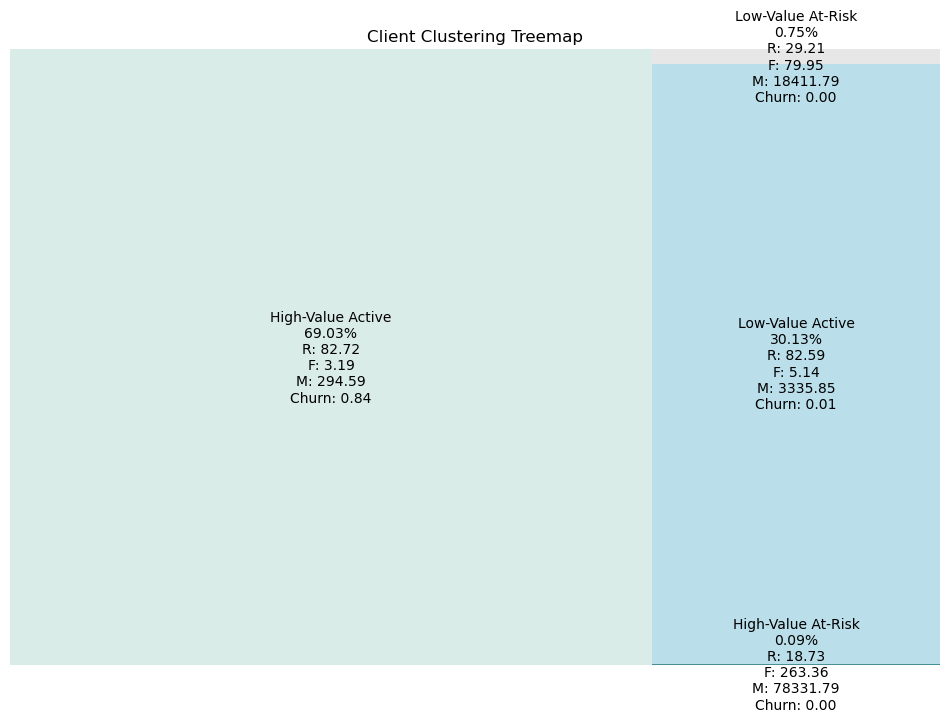

                                               Client_ID            Cluster
0                           100 LIMITES TRANSPORTES LTDA  High-Value Active
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...  High-Value Active
2                                   153 TRANSPORTES LTDA  High-Value Active
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS  High-Value Active
4                    19.450.581 JARDEL DE ABREU SANDOVAL  High-Value Active
...                                                  ...                ...
12103                              ZOOM TRANSPORTES LTDA  High-Value Active
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA  High-Value Active
12105                            ZORTEA CONSTRUCOES LTDA  High-Value Active
12106                     ZT COMERCIO E TRANSPORTES LTDA  High-Value Active
12107                          ZUCOLOTO TRANSPORTES LTDA  High-Value Active

[12108 rows x 2 columns]


In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import squarify

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Brand_Name'].fillna('Unknown', inplace=True)
    data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])
    today = datetime.now()
    data['Recency'] = (today - data['Sales_Date']).dt.days
    rfm = data.groupby('Client_ID').agg({
        'Recency': 'min',
        'Sales_Date': 'count',  # Frequency
        'Monetary_Value': 'sum'  # Monetary
    }).rename(columns={'Sales_Date': 'Frequency'}).reset_index()
    return rfm

def calculate_churn_index(rfm):
    def churn_index(row):
        return (1 / (row['Frequency'] + 1)) * row['Recency'] * (1 / (row['Monetary_Value'] + 1))
    rfm['Churn_Index'] = rfm.apply(churn_index, axis=1)
    return rfm

def normalize_features(rfm):
    scaler = MinMaxScaler(feature_range=(0, 100))
    return rfm

class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])
    
    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

def train_dcn(features, input_dim, latent_dim=3, epochs=10, batch_size=256):
    dcn = DCN(input_dim, latent_dim)
    dcn.compile(optimizer='adam', loss='mse')
    dcn.fit(features, features, epochs=epochs, batch_size=batch_size, verbose=1)
    latent_features = dcn.encoder.predict(features)
    return latent_features

def perform_clustering(latent_features, rfm, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent_features)
    rfm['Cluster'] = kmeans.labels_
    return rfm

def define_cluster_names(rfm):
    cluster_names = ["High-Value Active", "High-Value At-Risk", "Low-Value Active", "Low-Value At-Risk"]
    rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(4), cluster_names)))
    return rfm

def plot_treemap(rfm):
    cluster_stats = rfm.groupby('Cluster').agg({
        'Client_ID': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': 'mean',
        'Churn_Index': 'mean'
    }).rename(columns={'Client_ID': 'Count'}).reset_index()
    
    cluster_stats['Percentage'] = (cluster_stats['Count'] / cluster_stats['Count'].sum()) * 100
    cluster_stats['Label'] = cluster_stats.apply(lambda row: f"{row['Cluster']}\n{row['Percentage']:.2f}%\nR: {row['Recency']:.2f}\nF: {row['Frequency']:.2f}\nM: {row['Monetary_Value']:.2f}\nChurn: {row['Churn_Index']:.2f}", axis=1)
    
    sizes = cluster_stats['Percentage'].tolist()
    labels = cluster_stats['Label'].tolist()
    colors = ["#D1E8E2", "#19747E", "#A9D6E5", "#E2E2E2"]
    
    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=colors)
    plt.axis('off')
    plt.title('Client Clustering Treemap')
    plt.show()

def save_clustering_results(rfm, output_file_path):
    rfm.to_csv(output_file_path, index=False)

# Main code execution
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
output_file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Clustering_Results.csv'

# Load and preprocess data
rfm = load_and_preprocess_data(file_path)

# Calculate churn index
rfm = calculate_churn_index(rfm)

# Normalize features
rfm = normalize_features(rfm)

# Train DCN
input_dim = rfm.shape[1] - 1  # Exclude Client_ID
features = rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']].values
latent_features = train_dcn(features, input_dim)

# Perform clustering
rfm = perform_clustering(latent_features, rfm)

# Define cluster names
rfm = define_cluster_names(rfm)

# Plot treemap
plot_treemap(rfm)

# Save clustering results
save_clustering_results(rfm, output_file_path)

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


Epoch 1/10
48/48 [==============================] - 2s 6ms/step - loss: 136.2048
Epoch 2/10
48/48 [==============================] - 0s 7ms/step - loss: 4.1905
Epoch 3/10
48/48 [==============================] - 0s 6ms/step - loss: 2.5193
Epoch 4/10
48/48 [==============================] - 0s 6ms/step - loss: 1.4369
Epoch 5/10
48/48 [==============================] - 0s 5ms/step - loss: 0.7243
Epoch 6/10
48/48 [==============================] - 0s 6ms/step - loss: 0.4994
Epoch 7/10
48/48 [==============================] - 0s 6ms/step - loss: 0.3499
Epoch 8/10
48/48 [==============================] - 0s 9ms/step - loss: 0.2456
Epoch 9/10
48/48 [==============================] - 0s 6ms/step - loss: 0.1738
Epoch 10/10
379/379 [==============================] - 1s 2ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


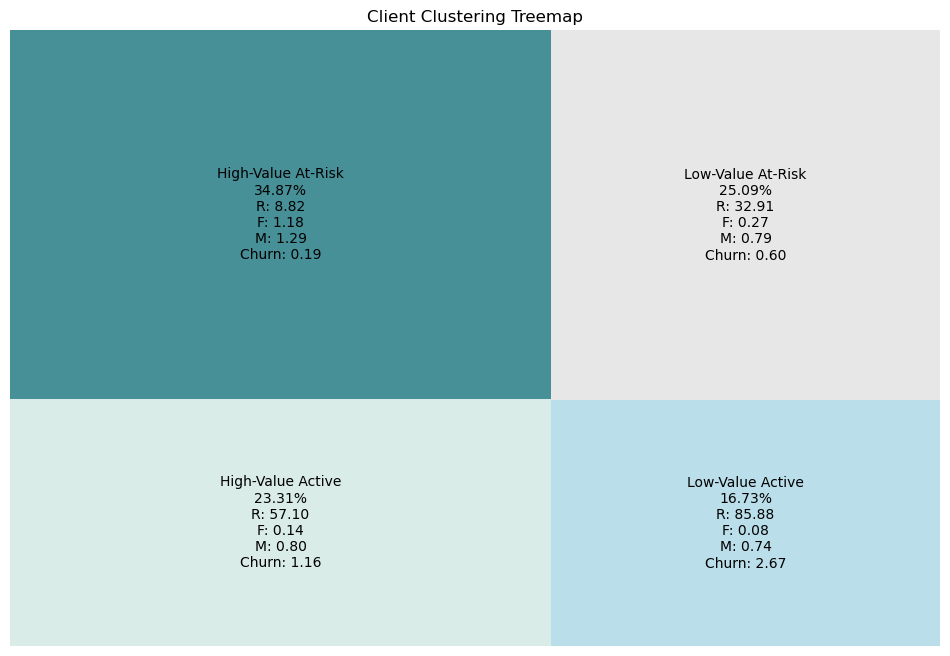

                                               Client_ID             Cluster
0                           100 LIMITES TRANSPORTES LTDA  High-Value At-Risk
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...   High-Value Active
2                                   153 TRANSPORTES LTDA   High-Value Active
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS    Low-Value Active
4                    19.450.581 JARDEL DE ABREU SANDOVAL  High-Value At-Risk
...                                                  ...                 ...
12103                              ZOOM TRANSPORTES LTDA   Low-Value At-Risk
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA   Low-Value At-Risk
12105                            ZORTEA CONSTRUCOES LTDA    Low-Value Active
12106                     ZT COMERCIO E TRANSPORTES LTDA    Low-Value Active
12107                          ZUCOLOTO TRANSPORTES LTDA   High-Value Active

[12108 rows x 2 columns]


In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import squarify

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Brand_Name'].fillna('Unknown', inplace=True)
    data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])
    today = datetime.now()
    data['Recency'] = (today - data['Sales_Date']).dt.days
    rfm = data.groupby('Client_ID').agg({
        'Recency': 'min',
        'Sales_Date': 'count',  # Frequency
        'Monetary_Value': 'sum'  # Monetary
    }).rename(columns={'Sales_Date': 'Frequency'}).reset_index()
    return rfm

def calculate_churn_index(rfm):
    def churn_index(row):
        return row['Recency'] * (1 / (row['Frequency'] + 1)) * (1 / (row['Monetary_Value'] + 1))
    rfm['Churn_Index'] = rfm.apply(churn_index, axis=1)
    return rfm

def normalize_features(rfm):
    scaler = MinMaxScaler(feature_range=(0, 100))
    rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']])
    return rfm

class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])
    
    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

def train_dcn(features, input_dim, latent_dim=3, epochs=10, batch_size=256):
    dcn = DCN(input_dim, latent_dim)
    dcn.compile(optimizer='adam', loss='mse')
    dcn.fit(features, features, epochs=epochs, batch_size=batch_size, verbose=1)
    latent_features = dcn.encoder.predict(features)
    return latent_features

def perform_clustering(latent_features, rfm, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent_features)
    rfm['Cluster'] = kmeans.labels_
    return rfm

def define_cluster_names(rfm):
    cluster_summary = rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': 'mean',
        'Churn_Index': 'mean'
    }).reset_index()

    cluster_names = { 
        0: "High-Value Active", 
        1: "High-Value At-Risk", 
        2: "Low-Value Active", 
        3: "Low-Value At-Risk" 
    }
    
    rfm['Cluster'] = rfm['Cluster'].map(cluster_names)
    return rfm

def plot_treemap(rfm):
    cluster_stats = rfm.groupby('Cluster').agg({
        'Client_ID': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': 'mean',
        'Churn_Index': 'mean'
    }).rename(columns={'Client_ID': 'Count'}).reset_index()
    
    cluster_stats['Percentage'] = (cluster_stats['Count'] / cluster_stats['Count'].sum()) * 100
    cluster_stats['Label'] = cluster_stats.apply(lambda row: f"{row['Cluster']}\n{row['Percentage']:.2f}%\nR: {row['Recency']:.2f}\nF: {row['Frequency']:.2f}\nM: {row['Monetary_Value']:.2f}\nChurn: {row['Churn_Index']:.2f}", axis=1)
    
    sizes = cluster_stats['Percentage'].tolist()
    labels = cluster_stats['Label'].tolist()
    colors = ["#D1E8E2", "#19747E", "#A9D6E5", "#E2E2E2"]
    
    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=colors)
    plt.axis('off')
    plt.title('Client Clustering Treemap')
    plt.show()

def save_clustering_results(rfm, output_file_path):
    rfm.to_csv(output_file_path, index=False)

# Main code execution
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
output_file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Clustering_Results.csv'

# Load and preprocess data
rfm = load_and_preprocess_data(file_path)

# Calculate churn index
rfm = calculate_churn_index(rfm)

# Normalize features
rfm = normalize_features(rfm)

# Train DCN
input_dim = rfm.shape[1] - 1  # Exclude Client_ID
features = rfm[['Recency', 'Frequency', 'Monetary_Value', 'Churn_Index']].values
latent_features = train_dcn(features, input_dim)

# Perform clustering
rfm = perform_clustering(latent_features, rfm)

# Define cluster names
rfm = define_cluster_names(rfm)

# Plot treemap
plot_treemap(rfm)

# Save clustering results
save_clustering_results(rfm, output_file_path)

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])
